In [1]:
import torch
from torch import nn, Tensor, from_numpy
import torch.optim as optim
from denoising_diffusion_pytorch import Unet

from utils import get_data_generator, get_data_tensor
from config import load_config
import numpy as np

/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def replace_relu_with_leakyrelu(module, negative_slope=0.2):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, nn.LeakyReLU(negative_slope=negative_slope, inplace=True))
        else:
            replace_relu_with_leakyrelu(child, negative_slope)


class UNetGenerator(nn.Module):
    def __init__(self, lat_dim: int = 32):
        super().__init__()
        self.latent_dim = lat_dim
        self.project_z = nn.Linear(lat_dim, 32 * 32)
        self.unet = Unet(
            dim=64,
            dim_mults=(1, 2, 4, 4),
            channels=1,
            flash_attn=True,
        )

        replace_relu_with_leakyrelu(self.unet, negative_slope=0.2)

    def forward(self, x: Tensor) -> Tensor:
        # z = torch.randn(len(x), self.latent_dim, device=x.device) 
        # proj = 1e-1 * self.project_z(z).view(z.shape[0], 1, 32, 32)
        t = torch.zeros(len(x), device=x.device)
        return self.unet(x, t)  # U-Net outputs an image


class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (B, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (B, 256, 3, 3)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (B, 512, 3, 3)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling (B, 512, 1, 1)
            nn.Flatten(),  # (B, 512)
            nn.Linear(512, 1),  # Single probability score
        )

    def forward(self, img: Tensor) -> Tensor:
        return self.model(img)  # Outputs logits


    def forward(self, img: Tensor) -> Tensor:
        return self.model(img).view(-1, 1)  # Output a single probability per image


class GAN(nn.Module):
    def __init__(self, lat_dim: int = 32):
        super().__init__()
        self.generator = UNetGenerator(lat_dim)
        self.discriminator = Discriminator()

    def generate(self, z: Tensor) -> Tensor:
        return self.generator(z)

    def discriminate(self, img: Tensor) -> Tensor:
        return self.discriminator(img)


In [3]:
#data
batch_size = 256

config = load_config()
train_data = get_data_tensor(config)
train_data_generator = get_data_generator(train_data, batch_size=batch_size)
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_flattening_temp_unbiased_schedule_10_steps_samples.npz")["x"]
)
sampled_data_generator = get_data_generator(sampled_data, batch_size=batch_size)

# Hyperparameters
latent_dim = 32
lr = 2e-4
total_iters = 1000

# Initialize models
device = "cuda" if torch.cuda.is_available() else "cpu"
gan = GAN(latent_dim).to(device)
generator, discriminator = gan.generator, gan.discriminator

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCEWithLogitsLoss()

# labels
real_labels = torch.ones((batch_size, 1), device=device)
soft_real_labels = torch.full((batch_size, 1), 0.9, device=device)
soft_fake_labels = torch.full((batch_size, 1), 0.1, device=device)

# Training loop
for it in range(total_iters):
    # Train Discriminator
    optimizer_D.zero_grad()

    real_imgs = next(train_data_generator).to(device)
    real_loss = criterion(discriminator(real_imgs), soft_real_labels)

    samples = next(sampled_data_generator).to(device)
    fake_imgs = generator(samples)
    fake_loss = criterion(discriminator(fake_imgs.detach()), soft_fake_labels)

    loss_D = 0.5 * (real_loss + fake_loss)
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    for _ in range(2):
        optimizer_G.zero_grad()

        samples = next(sampled_data_generator).to(device)
        fake_imgs = generator(samples)
        loss_G = criterion(discriminator(fake_imgs), real_labels)
        reg_G = 1e1 * (samples - fake_imgs).square().mean()

        (loss_G + reg_G).backward()
        optimizer_G.step()

    print(f"Iter {it}: real D Loss = {real_loss.item():.4f}, fake D Loss = {fake_loss.item():.4f}, G Loss = {loss_G.item():.4f}, G Reg = {reg_G.item():.4f}")

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


Iter 0: real D Loss = 0.7713, fake D Loss = 0.6239, G Loss = 0.7722, G Reg = 13.2233
Iter 1: real D Loss = 0.7435, fake D Loss = 0.6434, G Loss = 0.7844, G Reg = 0.6206
Iter 2: real D Loss = 0.7273, fake D Loss = 0.6492, G Loss = 0.7755, G Reg = 0.3514
Iter 3: real D Loss = 0.7195, fake D Loss = 0.6380, G Loss = 0.7857, G Reg = 0.2196
Iter 4: real D Loss = 0.7103, fake D Loss = 0.6371, G Loss = 0.7865, G Reg = 0.1469
Iter 5: real D Loss = 0.7048, fake D Loss = 0.6325, G Loss = 0.7845, G Reg = 0.1075
Iter 6: real D Loss = 0.7001, fake D Loss = 0.6385, G Loss = 0.7698, G Reg = 0.0746
Iter 7: real D Loss = 0.6956, fake D Loss = 0.6513, G Loss = 0.7553, G Reg = 0.0504
Iter 8: real D Loss = 0.7001, fake D Loss = 0.6625, G Loss = 0.7295, G Reg = 0.0478
Iter 9: real D Loss = 0.7080, fake D Loss = 0.6770, G Loss = 0.7190, G Reg = 0.0563
Iter 10: real D Loss = 0.7143, fake D Loss = 0.6767, G Loss = 0.7037, G Reg = 0.2097
Iter 11: real D Loss = 0.7094, fake D Loss = 0.6592, G Loss = 0.6869, G Re

In [4]:
samples = next(sampled_data_generator).to(device)
imgs = gan.generate(samples).detach().cpu().squeeze(1)

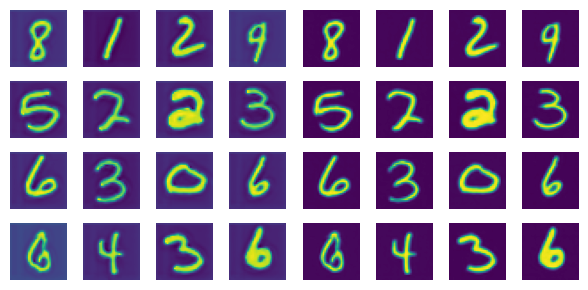

In [5]:
import matplotlib.pyplot as plt


imgs = imgs.squeeze(1)
samples = samples.squeeze(1).cpu()

fig, axes = plt.subplots(4, 8, figsize=(6, 3))
axes = axes.flatten()
for row in range(4):
    for i in range(4):
        axes[row * 8 + i].imshow(imgs[row * 4 + i])
        axes[row * 8 + i + 4].imshow(samples[row * 4 + i])

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

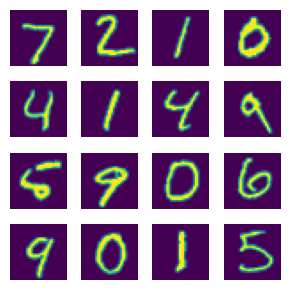

In [6]:
test_data = get_data_tensor(config, train=False).squeeze(1)

fig, axes = plt.subplots(4, 4, figsize=(3, 3))
axes = axes.flatten()
for row in range(4):
    for i in range(4):
        axes[row * 4 + i].imshow(test_data[row * 4 + i])

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import DataLoader
from tqdm import tqdm


gan_samples = torch.cat([gan.generate(batch.to(device)).detach().cpu() for batch in tqdm(DataLoader(sampled_data, batch_size=500))], dim=0)

  0%|          | 0/120 [00:00<?, ?it/s]/opt/conda/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
100%|██████████| 120/120 [00:09<00:00, 12.27it/s]


In [8]:
from utils import extract_features_statistics, get_data_tensor, LeNet, compute_fid


lenet = LeNet(1024, 10).to(device)
lenet.load_state_dict(torch.load(f"checkpoints/lenet_{config.data.dataset_name}.pth"))

mu_test, sigma_test = extract_features_statistics(test_data, lenet)

mu, sigma = extract_features_statistics(gan_samples, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

/home/coder/tmp/ipykernel_527556/3142025993.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet.load_state_dict(torch.load(f"checkpoints/lenet_{config.data.dataset_nam

(36.136208, 38.32332976334061, 74.45953734390702)

In [9]:
mu, sigma = extract_features_statistics(sampled_data, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

(1.2306006, 3.4557245423413927, 4.686325137815636)

In [30]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_linear_beta_schedule_20_steps_samples.npz")["x"]
)
mu, sigma = extract_features_statistics(sampled_data, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

(0.8768349, 2.7016855663155175, 3.578520495304928)

In [31]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_cosine_schedule_20_steps_samples.npz")["x"]
)
mu, sigma = extract_features_statistics(sampled_data, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

(0.53193235, 1.8221521894783743, 2.354084543451763)

In [32]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_flattening_temp_unbiased_schedule_20_steps_samples.npz")["x"]
)
mu, sigma = extract_features_statistics(sampled_data, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

(0.36682552, 1.5258623014791333, 1.8926878224714123)

In [39]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_flattening_temp_unbiased_schedule_20_steps_samples.npz")["x"]
)
mu, sigma = extract_features_statistics(train_data, lenet)
compute_fid(mu, sigma, mu_test, sigma_test)

(0.09208611, 0.8146739418550264, 0.906760048393799)

In [33]:
import torch
import lpips
from itertools import combinations
from tqdm import tqdm


lpips_model = lpips.LPIPS(net='vgg').cuda()


def compute_pairwise_lpips(imgs):
    pairwise_scores = []

    n = len(imgs)
    for i, j in tqdm(combinations(range(n), 2), total=n * (n - 1) // 2):
        with torch.no_grad():
            pairwise_scores.append(lpips_model(imgs[i], imgs[j]).item())

    return pairwise_scores

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lpips/weights/v0.1/vgg.pth


/home/coder/.local/lib/python310-conda-cuda-torch21/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pat

In [34]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_linear_beta_schedule_100_steps_samples.npz")["x"]
)[:100].cuda()
np.mean(compute_pairwise_lpips(sampled_data))

100%|██████████| 4950/4950 [00:18<00:00, 266.44it/s]


0.301427874094007

In [35]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_cosine_schedule_100_steps_samples.npz")["x"]
)[:100].cuda()
np.mean(compute_pairwise_lpips(sampled_data))

100%|██████████| 4950/4950 [00:18<00:00, 261.35it/s]


0.3192035605784769

In [36]:
sampled_data = from_numpy(
    np.load("results/mnist_50000_iter_flattening_temp_unbiased_schedule_100_steps_samples.npz")["x"]
)[:100].cuda()
np.mean(compute_pairwise_lpips(sampled_data))

100%|██████████| 4950/4950 [00:18<00:00, 267.60it/s]


0.31063633171070104

In [37]:
np.mean(compute_pairwise_lpips(test_data[:100].cuda()))

100%|██████████| 4950/4950 [00:18<00:00, 266.28it/s]


0.31900619192481644